In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Define paths
BASE_DIR = "/content/drive/My Drive/Clothing Segmentation"
MODEL_PATH = os.path.join(BASE_DIR, "checkpoints", "deeplabv3_pytorch.pth")
TEST_IMAGES_DIR = os.path.join(BASE_DIR, "dataset", "test", "images")
TEST_MASKS_DIR = os.path.join(BASE_DIR, "dataset", "test", "masks")
LABELS_CSV_PATH = os.path.join(BASE_DIR, "dataset", "labels.csv")

In [4]:
# Load class labels
if os.path.exists(LABELS_CSV_PATH):
    class_df = pd.read_csv(LABELS_CSV_PATH)
    class_names = class_df['label_list'].tolist()
else:
    class_names = [f"Class_{i}" for i in range(59)]  # Default for 59 classes

NUM_CLASSES = len(class_names)
print(NUM_CLASSES)

59


In [5]:
# Load PyTorch DeepLabV3+ model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
# Define model without the auxiliary classifier
model = deeplabv3_resnet50(num_classes=NUM_CLASSES, aux_loss=True)  # Make sure aux_loss is True if it was used during training

# Load the checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Remove auxiliary classifier weights from the checkpoint
filtered_checkpoint = {k: v for k, v in checkpoint.items() if "aux_classifier" not in k}

# Load the filtered state dictionary
model.load_state_dict(filtered_checkpoint, strict=False)  # strict=False allows missing keys

model.to(device)
model.eval()  # Set to evaluation mode
print("Model successfully loaded!")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]
<ipython-input-6-92228e8382fc>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded 

Model successfully loaded!


In [19]:
# Preprocessing function for images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [20]:
def preprocess_image(image_path):
    """Load and preprocess an input image."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error loading image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = transform(image)
    return image

In [21]:
# Function to compute IoU
def calculate_iou(y_true, y_pred, num_classes=NUM_CLASSES):
    """Calculate per-class and mean IoU."""
    ious = []
    for cls in range(num_classes):
        intersection = np.logical_and(y_true == cls, y_pred == cls).sum()
        union = np.logical_or(y_true == cls, y_pred == cls).sum()
        iou = intersection / union if union > 0 else 0
        ious.append(iou)
    mean_iou = np.mean(ious)
    return ious, mean_iou

In [22]:
# Function to compute Dice coefficient
def dice_coefficient(y_true, y_pred, num_classes=NUM_CLASSES):
    """Calculate per-class and mean Dice coefficient."""
    dice_scores = []
    for cls in range(num_classes):
        intersection = np.logical_and(y_true == cls, y_pred == cls).sum()
        dice = (2 * intersection) / (np.sum(y_true == cls) + np.sum(y_pred == cls)) if (np.sum(y_true == cls) + np.sum(y_pred == cls)) > 0 else 0
        dice_scores.append(dice)
    mean_dice = np.mean(dice_scores)
    return dice_scores, mean_dice

In [36]:
# Function to evaluate model on a single image
def evaluate_single_image(image_path, mask_path):
    """Evaluate segmentation on a single image."""
    original_image = preprocess_image(image_path).to(device).unsqueeze(0)  # Add batch dimension

    # Load ground truth mask
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.resize(gt_mask, (256, 256))

    # Predict mask
    with torch.no_grad():
        output = model(original_image)['out']
        pred_mask = torch.argmax(F.softmax(output, dim=1), dim=1).squeeze().cpu().numpy()

    # Compute Metrics
    ious, mean_iou = calculate_iou(gt_mask, pred_mask)
    dice_scores, mean_dice = dice_coefficient(gt_mask, pred_mask)
    pixel_accuracy = np.mean(gt_mask == pred_mask)

    print("Model Output Shape:", output.shape)  # Should be [1, 59, H, W]
    print(torch.unique(torch.argmax(output, dim=1)))
    print("Unique labels in evaluate_single_image output:", np.unique(pred_mask))
    # Print results
    print(f"\nEvaluation for {os.path.basename(image_path)}:")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")

    for i, class_name in enumerate(class_names):
        print(f"{class_name}: IoU={ious[i]:.4f}, Dice={dice_scores[i]:.4f}")

    # Visualization
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image.squeeze(0).permute(1, 2, 0).cpu().numpy())
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(gt_mask, cmap='tab20b')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='tab20b')
    plt.axis("off")

    plt.show()


In [24]:
# Evaluate on sample images
test_images = sorted(os.listdir(TEST_IMAGES_DIR))
test_masks = sorted(os.listdir(TEST_MASKS_DIR))

In [35]:
from PIL import Image
# Function to inspect predicted and ground truth masks
def inspect_prediction(model, image_path, mask_path, image_size=(512, 512)):

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Load and preprocess ground truth mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)

    # Move to device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image_tensor = image_tensor.to(device)

    # Get model prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)["out"]  # Get segmentation output
        predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy() # Convert to class labels

    print("Unique labels in inspect_prediction output:", np.unique(predicted_mask))
    # Display unique classes in masks
    print("Unique labels in Ground Truth Mask:", np.unique(mask))
    print("Unique labels in Predicted Mask:", np.unique(predicted_mask))

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="jet")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(predicted_mask, cmap="jet")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

Model Output Shape: torch.Size([1, 59, 256, 256])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Unique labels in evaluate_single_image output: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

Evaluation for img_0007.jpeg:
Mean IoU: 0.0169
Mean Dice Coefficient: 0.0174
Pixel Accuracy: 0.6934
nan: IoU=0.9743, Dice=0.9870
accessories: IoU=0.0020, Dice=0.0040
bag: IoU=0.0116, Dice=0.0230
belt: IoU=0.0003, Dice=0.0006
blazer: IoU=0.0026, Dice=0.0053
blouse: IoU=0.0000, Dice=0.0000
bodysuit: IoU=0.0000, Dice=0.0000
boots: IoU=0.0000, Dice=0.0000
bra: IoU=0.0000, Dice=0.0000
bracelet: IoU=0.0033, Dice=0.0066
cape: IoU=0.0000, Dice=0.0000
cardigan: IoU=0.0000, Dice=0.0000
clogs: IoU=0.0003, Dice=0.0005
coat: IoU=0.0000, Dice=0.0000
dress: IoU=0.0000, Dice=0.0000
earrings: IoU=0.0000, Dice=0.0000
flats: IoU=0.0000, Dice=0.0000
glasses: IoU=0.0000, Dice=0.0000
gloves: IoU=0.0000, Dice=0.0000
hair: IoU=0.0000, Dice=0.0000
hat: IoU=0.0000, Dice=0.0000
heels: IoU=0.0000, Dice=0.0000
hoodie:

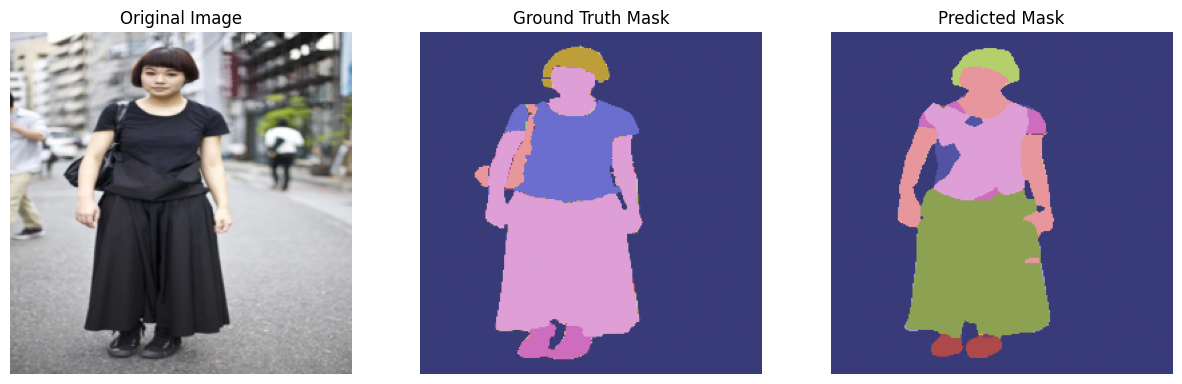

Model Output Shape: torch.Size([1, 59, 256, 256])
tensor([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10])
Unique labels in evaluate_single_image output: [ 0  1  2  3  4  5  7  8  9 10]

Evaluation for img_0026.jpeg:
Mean IoU: 0.0169
Mean Dice Coefficient: 0.0172
Pixel Accuracy: 0.7942
nan: IoU=0.9827, Dice=0.9913
accessories: IoU=0.0028, Dice=0.0056
bag: IoU=0.0000, Dice=0.0000
belt: IoU=0.0000, Dice=0.0000
blazer: IoU=0.0000, Dice=0.0000
blouse: IoU=0.0004, Dice=0.0008
bodysuit: IoU=0.0000, Dice=0.0000
boots: IoU=0.0000, Dice=0.0000
bra: IoU=0.0000, Dice=0.0000
bracelet: IoU=0.0100, Dice=0.0198
cape: IoU=0.0000, Dice=0.0000
cardigan: IoU=0.0000, Dice=0.0000
clogs: IoU=0.0000, Dice=0.0000
coat: IoU=0.0000, Dice=0.0000
dress: IoU=0.0000, Dice=0.0000
earrings: IoU=0.0000, Dice=0.0000
flats: IoU=0.0000, Dice=0.0000
glasses: IoU=0.0000, Dice=0.0000
gloves: IoU=0.0000, Dice=0.0000
hair: IoU=0.0000, Dice=0.0000
hat: IoU=0.0000, Dice=0.0000
heels: IoU=0.0000, Dice=0.0000
hoodie: IoU=0.0000, Dice=0.0

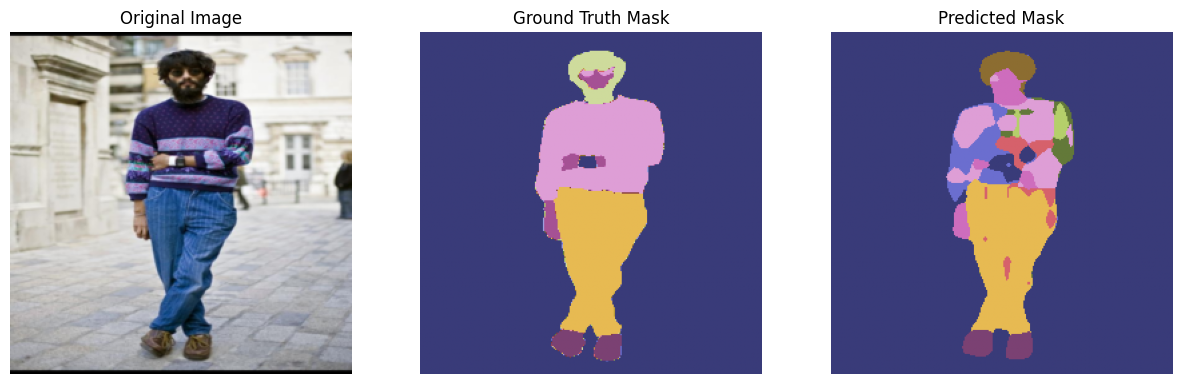

Model Output Shape: torch.Size([1, 59, 256, 256])
tensor([ 0,  1,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Unique labels in evaluate_single_image output: [ 0  1  4  5  6  7  8  9 10 11 12]

Evaluation for img_0028.jpeg:
Mean IoU: 0.0167
Mean Dice Coefficient: 0.0169
Pixel Accuracy: 0.7597
nan: IoU=0.9868, Dice=0.9934
accessories: IoU=0.0000, Dice=0.0000
bag: IoU=0.0000, Dice=0.0000
belt: IoU=0.0000, Dice=0.0000
blazer: IoU=0.0000, Dice=0.0000
blouse: IoU=0.0000, Dice=0.0000
bodysuit: IoU=0.0000, Dice=0.0000
boots: IoU=0.0003, Dice=0.0006
bra: IoU=0.0000, Dice=0.0000
bracelet: IoU=0.0010, Dice=0.0021
cape: IoU=0.0000, Dice=0.0000
cardigan: IoU=0.0000, Dice=0.0000
clogs: IoU=0.0000, Dice=0.0000
coat: IoU=0.0000, Dice=0.0000
dress: IoU=0.0000, Dice=0.0000
earrings: IoU=0.0000, Dice=0.0000
flats: IoU=0.0000, Dice=0.0000
glasses: IoU=0.0000, Dice=0.0000
gloves: IoU=0.0000, Dice=0.0000
hair: IoU=0.0000, Dice=0.0000
hat: IoU=0.0000, Dice=0.0000
heels: IoU=0.0000, Dice=0.0000
hoodie: IoU=0.0000, D

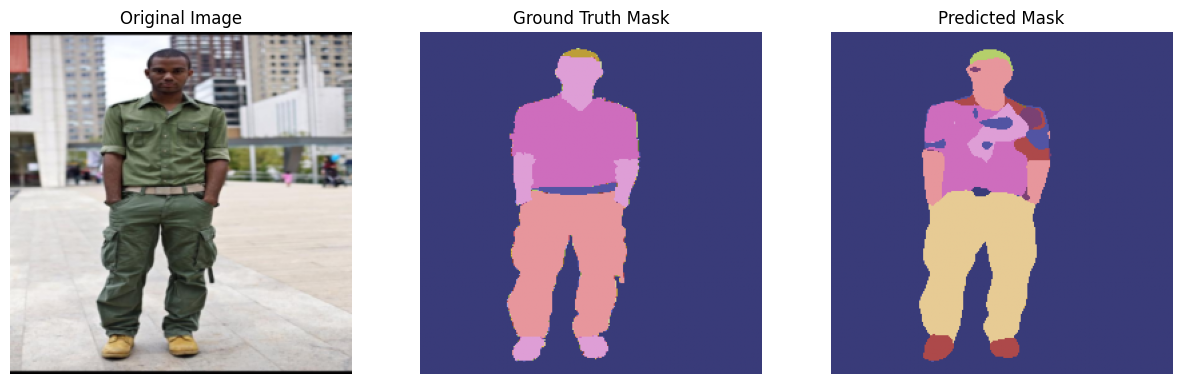

Model Output Shape: torch.Size([1, 59, 256, 256])
tensor([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 12])
Unique labels in evaluate_single_image output: [ 0  1  2  3  4  5  7  8  9 10 12]

Evaluation for img_0031.jpeg:
Mean IoU: 0.0215
Mean Dice Coefficient: 0.0248
Pixel Accuracy: 0.7632
nan: IoU=0.9857, Dice=0.9928
accessories: IoU=0.0067, Dice=0.0134
bag: IoU=0.0376, Dice=0.0724
belt: IoU=0.0000, Dice=0.0000
blazer: IoU=0.0000, Dice=0.0000
blouse: IoU=0.2395, Dice=0.3865
bodysuit: IoU=0.0000, Dice=0.0000
boots: IoU=0.0000, Dice=0.0000
bra: IoU=0.0000, Dice=0.0000
bracelet: IoU=0.0002, Dice=0.0004
cape: IoU=0.0000, Dice=0.0000
cardigan: IoU=0.0000, Dice=0.0000
clogs: IoU=0.0000, Dice=0.0000
coat: IoU=0.0000, Dice=0.0000
dress: IoU=0.0000, Dice=0.0000
earrings: IoU=0.0000, Dice=0.0000
flats: IoU=0.0000, Dice=0.0000
glasses: IoU=0.0000, Dice=0.0000
gloves: IoU=0.0000, Dice=0.0000
hair: IoU=0.0000, Dice=0.0000
hat: IoU=0.0000, Dice=0.0000
heels: IoU=0.0000, Dice=0.0000
hoodie: IoU=0.0000, D

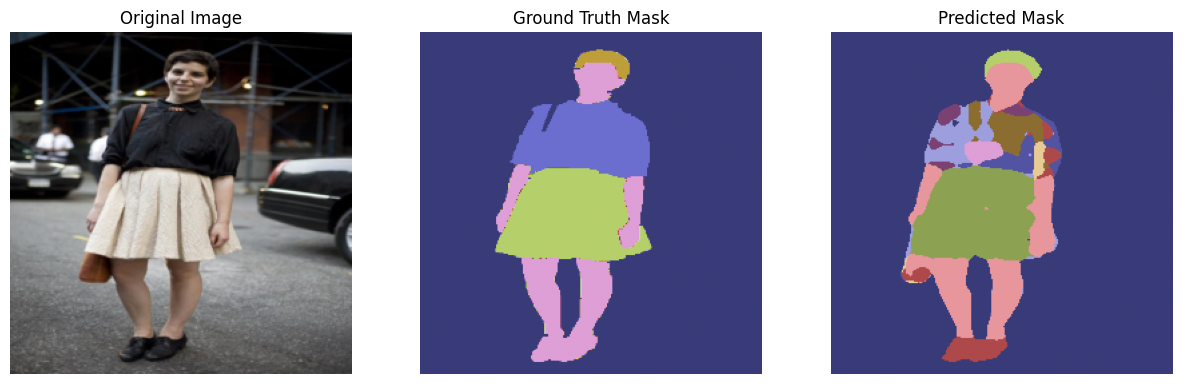

Model Output Shape: torch.Size([1, 59, 256, 256])
tensor([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12])
Unique labels in evaluate_single_image output: [ 0  1  2  3  4  5  7  8  9 10 11 12]

Evaluation for img_0033.jpeg:
Mean IoU: 0.0168
Mean Dice Coefficient: 0.0170
Pixel Accuracy: 0.7923
nan: IoU=0.9844, Dice=0.9921
accessories: IoU=0.0000, Dice=0.0000
bag: IoU=0.0000, Dice=0.0000
belt: IoU=0.0000, Dice=0.0000
blazer: IoU=0.0000, Dice=0.0000
blouse: IoU=0.0000, Dice=0.0000
bodysuit: IoU=0.0000, Dice=0.0000
boots: IoU=0.0000, Dice=0.0000
bra: IoU=0.0000, Dice=0.0000
bracelet: IoU=0.0069, Dice=0.0137
cape: IoU=0.0000, Dice=0.0000
cardigan: IoU=0.0000, Dice=0.0000
clogs: IoU=0.0000, Dice=0.0000
coat: IoU=0.0000, Dice=0.0000
dress: IoU=0.0000, Dice=0.0000
earrings: IoU=0.0000, Dice=0.0000
flats: IoU=0.0000, Dice=0.0000
glasses: IoU=0.0000, Dice=0.0000
gloves: IoU=0.0000, Dice=0.0000
hair: IoU=0.0000, Dice=0.0000
hat: IoU=0.0000, Dice=0.0000
heels: IoU=0.0000, Dice=0.0000
hoodie: IoU=0.

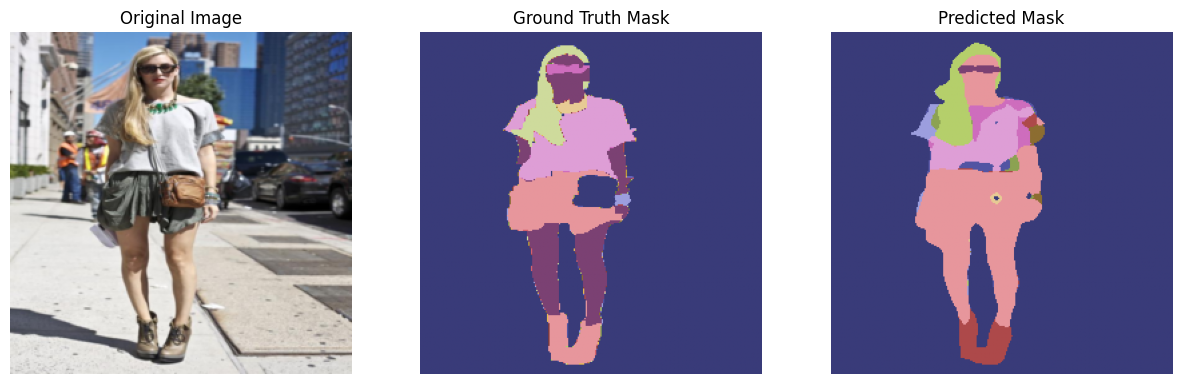

In [37]:
# Pick a few random samples for evaluation
num_samples = min(5, len(test_images))
for i in range(num_samples):
    image_path = os.path.join(TEST_IMAGES_DIR, test_images[i])
    mask_path = os.path.join(TEST_MASKS_DIR, test_masks[i])
    evaluate_single_image(image_path, mask_path)

Unique labels in Ground Truth Mask: [ 0  5 19 33 39 41 42]
Unique labels in Predicted Mask: [ 0  1  2  3  4  7  8  9 10 11 12]


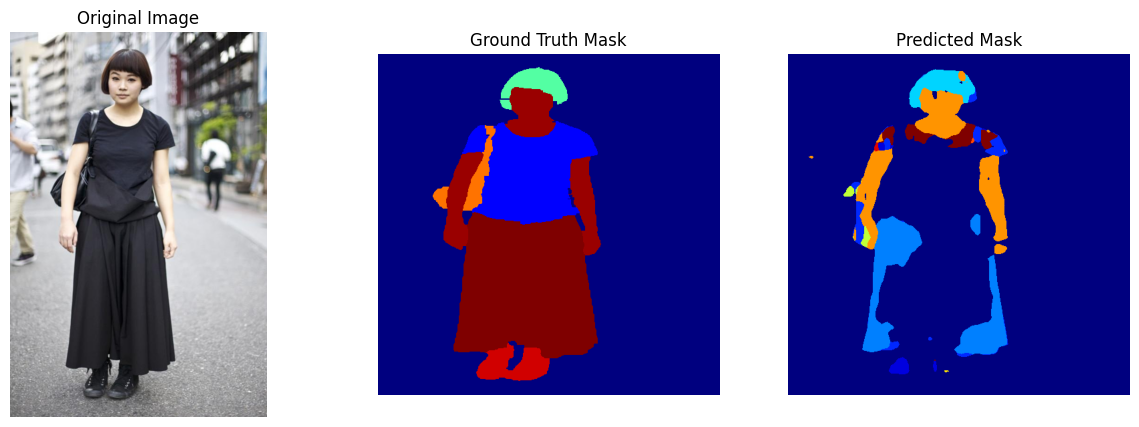

Unique labels in Ground Truth Mask: [ 0  1 19 25 39 41 47 48]
Unique labels in Predicted Mask: [ 0  1  2  3  4  5  7  8  9 10 12]


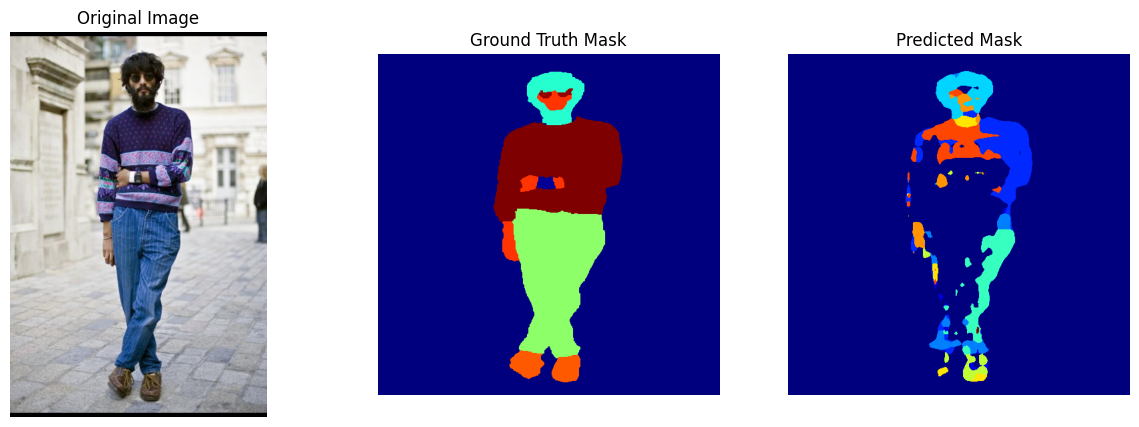

Unique labels in Ground Truth Mask: [ 0  3 19 31 38 39 41]
Unique labels in Predicted Mask: [ 0  1  2  3  4  5  6  7  8  9 10 12]


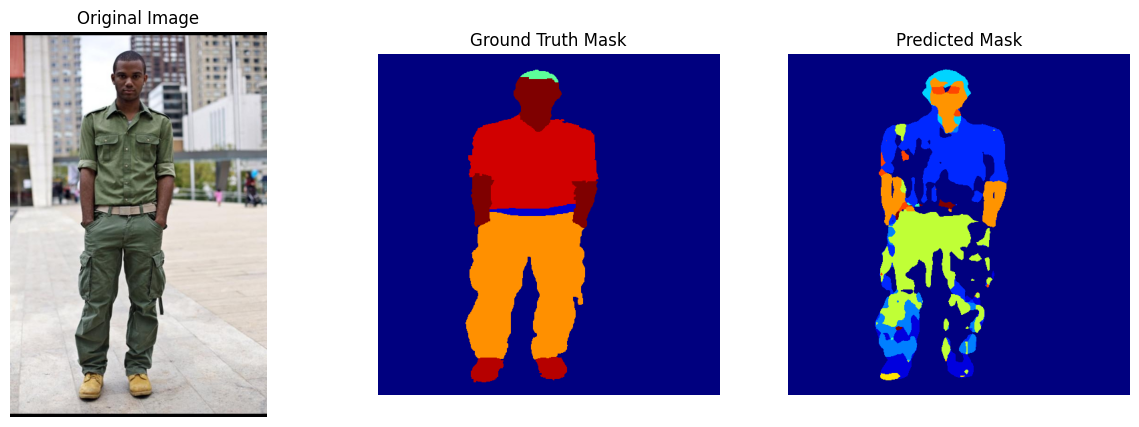

Unique labels in Ground Truth Mask: [ 0  2  5 14 19 39 41]
Unique labels in Predicted Mask: [ 0  1  2  3  4  5  7  8  9 10]


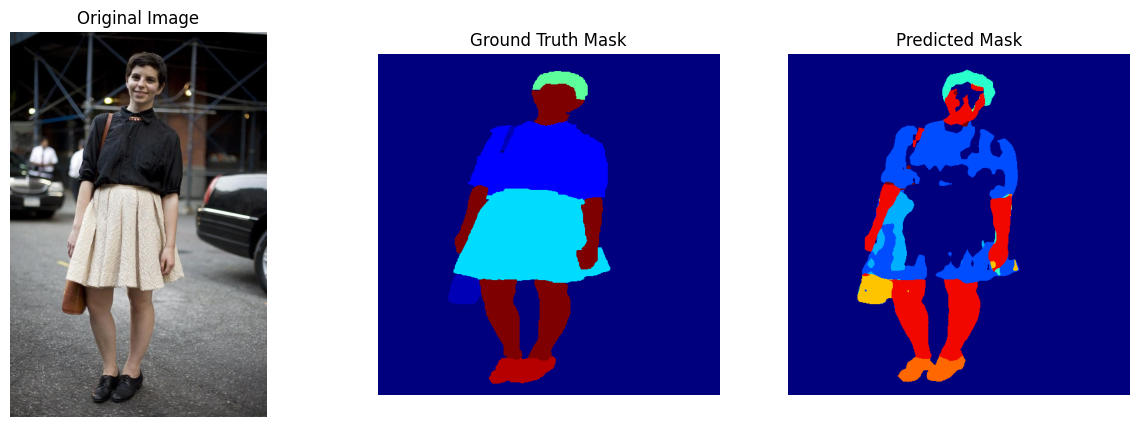

Unique labels in Ground Truth Mask: [ 0  2  9 19 29 39 40 41 47 51]
Unique labels in Predicted Mask: [ 0  1  2  3  4  5  6  7  8  9 10 12]


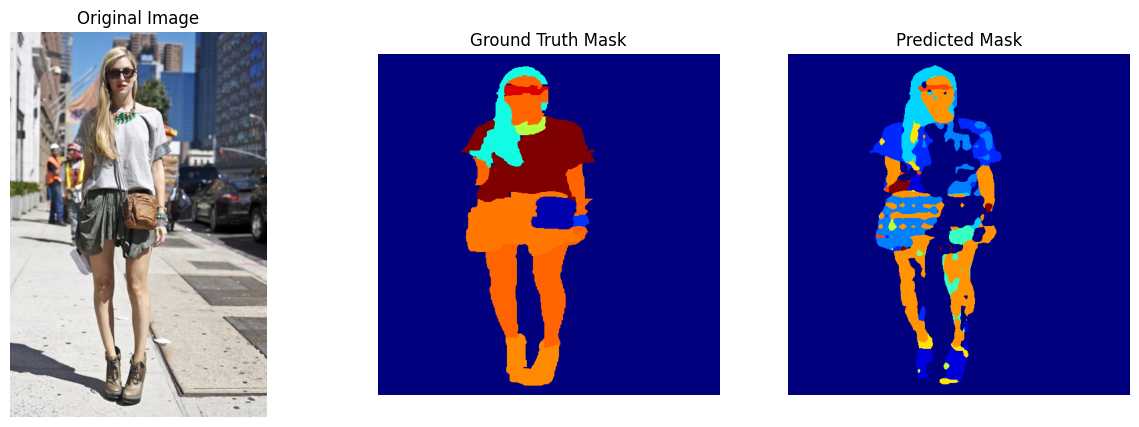

In [14]:
# Pick a few random samples for evaluation
num_samples = min(5, len(test_images))
for i in range(num_samples):
    image_path = os.path.join(TEST_IMAGES_DIR, test_images[i])
    mask_path = os.path.join(TEST_MASKS_DIR, test_masks[i])

    # Call the function
    inspect_prediction(model, image_path, mask_path)

In [15]:
print(model.classifier[-1].out_channels)  # Should be 59


59
